# Classification Modelling

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, cohen_kappa_score
import matplotlib.pyplot as plt
from joblib import dump

In [58]:
# Load Data
data = pd.read_csv('./data/clean_train.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PartySize,Deck,PortStarboard
0,0001_01,Europa,False,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,B,P
1,0002_01,Earth,False,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,F,S
2,0003_01,Europa,False,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,2,A,S
3,0003_02,Europa,False,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,A,S
4,0004_01,Earth,False,1,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,F,S


## Logistic Regression

Logistic Regression is a simple classification algorithm that provides a lot of information as well as a good baseline for model prediction performance based on a given dataset.

### Data Preparation

Logistic Regression is susceptible to scaling effects and skewed distributions, so some of the columns will need to be transformed prior to modelling.

In [59]:
# Function to log transform numeric data columns
def log_transform(col):
    return np.log(col+1)

# Function to scale numeric data columns
def scale_column(col):
    return (col - col.min()) / (col.max() - col.min())

In [63]:
data['log_scaled_RoomService'] = scale_column(log_transform(data['RoomService']))
data['log_scaled_FoodCourt'] = scale_column(log_transform(data['FoodCourt']))
data['log_scaled_ShoppingMall'] = scale_column(log_transform(data['ShoppingMall']))
data['log_scaled_Spa'] = scale_column(log_transform(data['Spa']))
data['log_scaled_VRDeck'] = scale_column(log_transform(data['VRDeck']))
data['scaled_Age'] = scale_column(data['Age'])
data['scaled_PartySize'] = scale_column(data['PartySize'])

data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,PartySize,Deck,PortStarboard,log_scaled_RoomService,log_scaled_FoodCourt,log_scaled_ShoppingMall,log_scaled_Spa,log_scaled_VRDeck,scaled_Age,scaled_PartySize
0,0001_01,Europa,False,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,1,B,P,0.000000,0.000000,0.000000,0.000000,0.000000,0.493671,0.000000
1,0002_01,Earth,False,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,1,F,S,0.491170,0.223493,0.323723,0.629907,0.377219,0.303797,0.000000
2,0003_01,Europa,False,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,2,A,S,0.395423,0.794185,0.000000,0.879710,0.387660,0.734177,0.142857
3,0003_02,Europa,False,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,2,A,S,0.000000,0.694741,0.588099,0.809679,0.522016,0.417722,0.142857
4,0004_01,Earth,False,1,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,F,S,0.597392,0.413743,0.499171,0.632770,0.108866,0.202532,0.000000


Logistic Regression can only handle numeric variables, so categorical variables will need to be converted to one-hot encoded variables.

In [64]:
#Seperate target from features
features = data.loc[:, data.columns != 'Transported']
target = data.loc[:,['Transported']]

# Remove unwanted columns
data_cleaned = features.drop(features.loc[:,['PassengerId','Cabin','Name','PassengerGroup','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Age','PartySize']], axis=1)

one_hot_encoded_data = pd.get_dummies(data_cleaned, columns = ['HomePlanet','Destination','Deck','PortStarboard'])

In [65]:
#Split data into Test and Train sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_data, target, random_state=1234, train_size = .75)

In [66]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
y_prob = model.predict_proba(X_test)
y_pred = pd.DataFrame(y_prob > .5)

predictors = X_train.columns.values

In [68]:
confusion_matrix(y_test, model.predict(X_test))

array([[837, 259],
       [234, 844]])

In [69]:
# Calculate Accuracy Score on Validation Set
acc = accuracy_score(y_test, y_pred[1])
# Calculate F-score
f1 = f1_score(y_test, y_pred[1])
# Calculate Precision
prec = precision_score(y_test, y_pred[1])
# Calculate Recall
rec = recall_score(y_test, y_pred[1])
# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred[1])

# Print Scores
print('Accuracy = ',acc)
print('F-Score = ',f1)
print('Precision = ', prec)
print('Recall = ', rec)
print('Kappa = ',kappa)

Accuracy =  0.7732290708371665
F-Score =  0.7739569005043558
Precision =  0.7651858567543064
Recall =  0.7829313543599258
Kappa =  0.5465134089241634


In [70]:
auc_score = roc_auc_score(y_test.iloc[:,0], y_prob[:,1])

In [71]:
coef = model.coef_

for p,c in zip(predictors,list(coef[0])):
    print(p + '\t' + str(c))
    
print('Intercept = ', model.intercept_)

CryoSleep	1.110547402969763
VIP	-0.24667971491275248
log_scaled_RoomService	-2.051431692081815
log_scaled_FoodCourt	1.0310427429885078
log_scaled_ShoppingMall	0.7855762411111806
log_scaled_Spa	-2.5586935353449274
log_scaled_VRDeck	-2.525975930746231
scaled_Age	-0.5404430521540561
scaled_PartySize	-0.006717556809748837
HomePlanet_Earth	-0.32525359209647603
HomePlanet_Europa	1.0735096351559796
HomePlanet_Mars	-0.03711224208374172
HomePlanet_unknown	-0.2908670643989598
Destination_55 Cancri e	0.2349442659244462
Destination_PSO J318.5-22	-0.07875011801947547
Destination_TRAPPIST-1e	-0.09368634290817261
Destination_unknown	0.3577689315795522
Deck_A	-0.25358861030718516
Deck_B	0.2142713462301406
Deck_C	0.676341714887663
Deck_D	0.16428620242506672
Deck_E	-0.2561032835317423
Deck_F	0.4156212185509038
Deck_G	-0.28677696382413753
Deck_T	-0.24012829537516156
Deck_unknown	-0.013646592478259728
PortStarboard_P	-0.0789525422699454
PortStarboard_S	0.5128758713252913
PortStarboard_unknown	-0.013646592

In [72]:
# Function to plot ROC Curve
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def my_range(start, end, how_many):
    incr = float(end - start)/(how_many - 1)
    return [start + i*incr for i in range(how_many-1)] + [end]

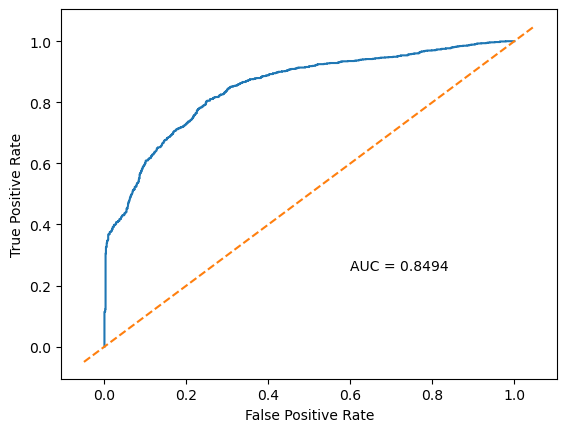

<Figure size 640x480 with 0 Axes>

In [91]:
plot_roc_curve(y_test.iloc[:,0], y_prob[:,1])
abline(1,0)
plt.text(0.6,0.25,('AUC = ' + str(round(auc_score,4))))
plt.show()
plt.savefig('logit_roc_auc.jpg')

In [74]:
auc_df = pd.DataFrame(columns=['threshold','AUC'])
c = 0
for i in my_range(0,1,101):
    y_pred = y_prob > i
    prob_auc_score = roc_auc_score(y_test.iloc[:,0],y_pred[:,1])
    auc_df.loc[c] = [i,prob_auc_score]
    c += 1

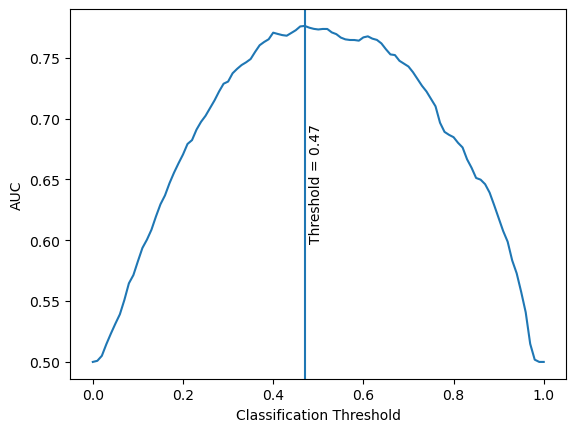

In [88]:
max_auc = auc_df.loc[auc_df['AUC'] == auc_df['AUC'].max(),'threshold']

plt.plot(auc_df.threshold, auc_df.AUC)
plt.xlabel('Classification Threshold')
plt.ylabel('AUC')
plt.axvline(max_auc.values[0])
plt.text((max_auc.values[0])+0.01,0.6,('Threshold = '+ str(round(max_auc.values[0], 2))),rotation=90)

plt.show()

In [85]:
max_auc.values[0]

0.47000000000000003

In [76]:
# Reevaluate with new threshold
y_pred = pd.DataFrame(y_prob > .47)

In [77]:
confusion_matrix(y_test, y_pred[1])

array([[819, 277],
       [210, 868]])

In [78]:
# Calculate Accuracy Score on Validation Set
acc = accuracy_score(y_test, y_pred[1])
# Calculate F-score
f1 = f1_score(y_test, y_pred[1])
# Calculate Precision
prec = precision_score(y_test, y_pred[1])
# Calculate Recall
rec = recall_score(y_test, y_pred[1])
# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred[1])

# Print Scores
print('Accuracy = ',acc)
print('F-Score = ',f1)
print('Precision = ', prec)
print('Recall = ', rec)
print('Kappa = ',kappa)

Accuracy =  0.7759889604415824
F-Score =  0.7809266756635177
Precision =  0.7580786026200873
Recall =  0.8051948051948052
Kappa =  0.5521757631180679


In [89]:
# Dump model into file
dump(model, './models/logit_liblinear.joblib')

['./models/logit_liblinear.joblib']